In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats-redux-kernels-edition/sample_submission.csv
/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip
/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip


## Datasets Checking and Pre-processing

In [15]:
import os
import zipfile
import shutil
from glob import glob
from tqdm import tqdm
import matplotlib.pyplot as plt
from PIL import Image

# Paths
zip_train_path = "/kaggle/input/dogs-vs-cats-redux-kernels-edition/train.zip"
zip_test_path = "/kaggle/input/dogs-vs-cats-redux-kernels-edition/test.zip"
train_extract_path = "/kaggle/working/train"
test_extract_path = "/kaggle/working/test"

# Step 1: Unzip the datasets
with zipfile.ZipFile(zip_train_path, "r") as zip_ref:
    zip_ref.extractall(train_extract_path)

with zipfile.ZipFile(zip_test_path, "r") as zip_ref:
    zip_ref.extractall(test_extract_path)

print("Datasets have been unzipped successfully.")

# Step 2: Adjust train_extract_path if needed
contents = os.listdir(train_extract_path)
print("Files/folders inside train_extract_path:", contents)

# Go into nested 'train/' folder if it exists
if 'train' in contents:
    train_extract_path = os.path.join(train_extract_path, 'train')
    print(f"Adjusted train_extract_path: {train_extract_path}")

# Set cat and dog directories
cat_dir = os.path.join(train_extract_path, "cat")
dog_dir = os.path.join(train_extract_path, "dog")
os.makedirs(cat_dir, exist_ok=True)
os.makedirs(dog_dir, exist_ok=True)

# Step 3: Move images into 'cat' and 'dog' folders
image_paths = glob(os.path.join(train_extract_path, "*.jpg"))
for img_path in image_paths:
    filename = os.path.basename(img_path)
    if filename.startswith("cat"):
        shutil.move(img_path, os.path.join(cat_dir, filename))
    elif filename.startswith("dog"):
        shutil.move(img_path, os.path.join(dog_dir, filename))

print("Training data organized into 'cat' and 'dog' folders.")

# Step 4: Sort test filenames numerically
test_img_folder = os.path.join(test_extract_path, "test")
test_filenames = sorted(
    [f for f in os.listdir(test_img_folder) if f.endswith(".jpg")],
    key=lambda x: int(x.split(".")[0])
)

print("Test filenames are sorted numerically.")
print("First 5 test images:", test_filenames[:5])
print("Last 5 test images:", test_filenames[-5:])

Datasets have been unzipped successfully.
Files/folders inside train_extract_path: ['train']
Adjusted train_extract_path: /kaggle/working/train/train
Training data organized into 'cat' and 'dog' folders.
Test filenames are sorted numerically.
First 5 test images: ['1.jpg', '2.jpg', '3.jpg', '4.jpg', '5.jpg']
Last 5 test images: ['12496.jpg', '12497.jpg', '12498.jpg', '12499.jpg', '12500.jpg']


### Check dataset and print training images

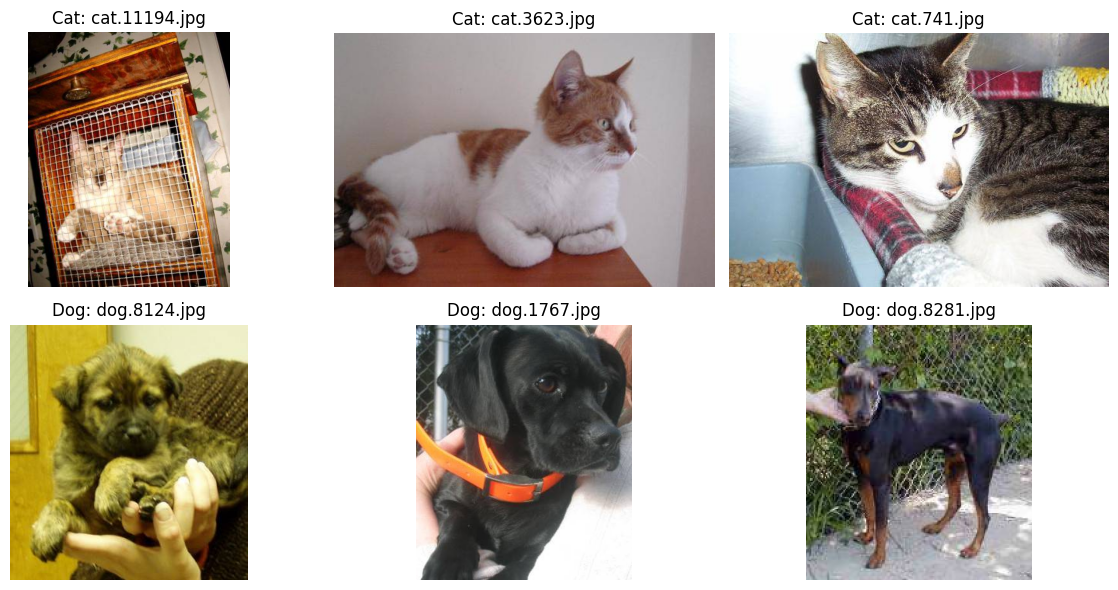

Number of cat images: 12500
Number of dog images: 12500


In [16]:
# Step 5: Display sample images from 'cat' and 'dog' folders
cat_images = os.listdir(cat_dir)[:3]
dog_images = os.listdir(dog_dir)[:3]

plt.figure(figsize=(12, 6))

# Plot cat images
for i, img_name in enumerate(cat_images):
    img_path = os.path.join(cat_dir, img_name)
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 1)
    plt.imshow(img)
    plt.title(f"Cat: {img_name}")
    plt.axis('off')

# Plot dog images
for i, img_name in enumerate(dog_images):
    img_path = os.path.join(dog_dir, img_name)
    img = Image.open(img_path)
    plt.subplot(2, 3, i + 4)
    plt.imshow(img)
    plt.title(f"Dog: {img_name}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Step 6: Confirm number of images
print(f"Number of cat images: {len(os.listdir(cat_dir))}")
print(f"Number of dog images: {len(os.listdir(dog_dir))}")

## Model 1: ResNet18

In [17]:
import os
from collections import Counter
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset, Subset
from torchvision import datasets, models, transforms
from torch.nn import functional as F
from torchvision import transforms
from PIL import Image
import pandas as pd

In [18]:
# 1. Define image transformations (resize and normalize)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

# 2. Load dataset using ImageFolder
data_dir = "/kaggle/working/train/train"  
dataset = datasets.ImageFolder(root=data_dir, transform=transform)

# 3. Split dataset into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

# Get all labels from the dataset
labels = [sample[1] for sample in dataset.samples]  # 0 = cat, 1 = dog

# Stratified split using sklearn
train_idx, val_idx = train_test_split(
    list(range(len(dataset))),
    test_size=0.2,
    stratify=labels,
    random_state=42
)

# Create Subset datasets
train_ds = Subset(dataset, train_idx)
val_ds = Subset(dataset, val_idx)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

print("Train class distribution:", Counter([label for _, label in train_ds]))
print("Validation class distribution:", Counter([label for _, label in val_ds]))

# 4. Initialize ResNet18 model and modify the final layer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)

# Freeze all pre-trained layers - stop updating the weights of all original ResNet layer
for param in model.parameters():
    param.requires_grad = False

# Replace the final fully connected layer for binary classification
model.fc = nn.Linear(model.fc.in_features, 2)
model = model.to(device)

# 5. Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# 6. Training and validation loop
num_epochs = 5
best_val_loss = float('inf')
best_model_path = "best_model.pth"

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}", leave=False)

    for inputs, labels in progress_bar:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())

    avg_train_loss = running_loss / len(train_loader)

    # Validation phase
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(val_loader)
    val_accuracy = correct / total

    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | "
          f"Val Loss: {avg_val_loss:.4f} | Val Accuracy: {val_accuracy:.4f}")

    # Save model if validation loss improves
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        torch.save(model.state_dict(), best_model_path)
        print(f"Best model saved at Epoch {epoch+1}")

# 7. Load the best model
model.load_state_dict(torch.load(best_model_path))
model.eval()
print("Best model loaded for final evaluation.")

Train class distribution: Counter({1: 10000, 0: 10000})
Validation class distribution: Counter({1: 2500, 0: 2500})


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 83.5MB/s]


Epoch 1 | Train Loss: 0.1169 | Val Loss: 0.0651 | Val Accuracy: 0.9742
Best model saved at Epoch 1


Epoch 2 | Train Loss: 0.0776 | Val Loss: 0.0595 | Val Accuracy: 0.9752
Best model saved at Epoch 2


Epoch 3 | Train Loss: 0.0766 | Val Loss: 0.0669 | Val Accuracy: 0.9738


Epoch 4 | Train Loss: 0.0791 | Val Loss: 0.0617 | Val Accuracy: 0.9748


Epoch 5 | Train Loss: 0.0701 | Val Loss: 0.0597 | Val Accuracy: 0.9750
Best model loaded for final evaluation.


/tmp/ipykernel_31/1585716909.py:111: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_path))


In [19]:
# 8. Dataset
class TestDataset(Dataset):
    def __init__(self, test_dir, transform=None):
        self.image_paths = sorted([os.path.join(test_dir, fname) 
                                   for fname in os.listdir(test_dir) if fname.endswith(".jpg")])
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        image_id = int(os.path.basename(img_path).split(".")[0])  # Extract image ID
        return img, image_id

# 9. Transform image data
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], 
                         [0.229, 0.224, 0.225])
])

# 10. Load Testing Data
test_dir = "/kaggle/working/test/test"
test_dataset = TestDataset(test_dir=test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# 11. Load Best Model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet18(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Change the final layer for 2 classes (dog/cat)
model.load_state_dict(torch.load("best_model.pth"))
model = model.to(device)
model.eval()

# 12. Prediction
all_ids = []
all_probs = []

with torch.no_grad():
    for images, image_ids in test_loader:
        images = images.to(device)
        outputs = model(images)
        
        # Apply softmax to get probabilities for each class
        probs = F.softmax(outputs, dim=1)  # Apply softmax to get probabilities across all classes
        
        # Extract probability for class 1 (dog class)
        probs_dog = probs[:, 1]  # Assuming class 1 is dog (binary classification)

        all_probs.extend(probs_dog.cpu().numpy())  # Store the predicted probabilities
        all_ids.extend([int(id_) for id_ in image_ids])  # Store image IDs

# === Submission ===
submission_df = pd.DataFrame({
    "id": all_ids,
    "label": all_probs  # Predicted probability of the dog class
}).sort_values("id")  # Sort by ID

# Save the submission file
submission_path = "/kaggle/working/submission.csv"
submission_df.to_csv(submission_path, index=False)

print(f"Submission saved to {submission_path}")

/tmp/ipykernel_31/3293928224.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pth"))


Submission saved to /kaggle/working/submission.csv
